In [4]:
using Pkg; haskey(Pkg.installed(),"Knet") || Pkg.add("Knet")
using Statistics: mean
using Base.Iterators: cycle
using Knet: Knet, AutoGrad, Data, param, param0, mat, RNN, dropout, value, nll, adam, minibatch, progress!, converge, Random

In [5]:
using Knet: TimerOutputs

In [6]:
# Set display width, load packages, import symbols
ENV["COLUMNS"]=72
using Pkg; for p in ("Knet","Plots"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Knet: Knet, dir, zeroone, progress, sgd, load, save, gc, Param, KnetArray, gpu, Data, nll, relu, training, dropout # param, param0, xavier
using Statistics: mean
using Base.Iterators: flatten

In [7]:
import LinearAlgebra

In [8]:
using Plots; default(fmt=:png,ls=:auto)

In [9]:
atype = Knet.gpu()>=0 ? Knet.KnetArray : Array

KnetArray

In [10]:
function load_data2(path)
    xtrain, ytrain = open(path) do f
    xtrain = []
    ytrain = []
    sentence = []
    arcs = []
    count = 1
    for i in enumerate(eachline(f))  
      if i[2] == ""
        push!(xtrain, sentence)
        labels = zeros(count, count)
        push!(ytrain, arcs)
      elseif i[2][1] != '#'
        temp = split(i[2])
        if temp[1] == "1"
            sentence = []
            arcs = []
            push!(sentence, temp[2])
            push!(arcs, parse(Int64, temp[7]))
            count = 1
        else
            push!(sentence, temp[2]) 
            if isnumeric(temp[7][1])
                push!(arcs, parse(Int64, temp[7]))
            else
                push!(arcs, 0)
            end
            count += 1
        end
      end
    end
    xtrain, ytrain
    end
    xtrain, ytrain
end

load_data2 (generic function with 1 method)

In [11]:
function load_embed(path)
    wembed, wembedind = open(path) do f
        wembed = Dict()
        wembedind = []
        for i in enumerate(eachline(f))
            line = i[2]
            tokens = split(line)
            key = tokens[1]
            temp = Array{Float32, 1}()
            for token in tokens[2:end]
                tmp = tryparse(Float32, token)
                append!(temp, tmp)
            end
            wembed[key] = i[1]
            push!(wembedind,temp)
        end
        wembed, wembedind
    end
    wembed, wembedind
end

load_embed (generic function with 1 method)

In [12]:
rootind = 399999

399999

In [13]:
function getind(word; max=400000, root=false)
    abc = get(wembed,lowercase(word),-1)
    if root == true
        return max-1
    elseif (abc >= 0)
        return abc
    else
        return max
    end
end

getind (generic function with 1 method)

In [14]:
data2 = load_data2("en_ewt-ud-train.conllu")

(Any[Any["Al", "-", "Zaman", ":", "American", "forces", "killed", "Shaikh", "Abdullah", "al"  …  "the", "town", "of", "Qaim", ",", "near", "the", "Syrian", "border", "."], Any["[", "This", "killing", "of", "a", "respected", "cleric", "will", "be", "causing", "us", "trouble", "for", "years", "to", "come", ".", "]"], Any["DPA", ":", "Iraqi", "authorities", "announced", "that", "they", "had", "busted", "up", "3", "terrorist", "cells", "operating", "in", "Baghdad", "."], Any["Two", "of", "them", "were", "being", "run", "by", "2", "officials", "of", "the", "Ministry", "of", "the", "Interior", "!"], Any["The", "MoI", "in", "Iraq", "is", "equivalent", "to", "the", "US", "FBI"  …  "members", "of", "the", "Weathermen", "bombers", "back", "in", "the", "1960s", "."], Any["The", "third", "was", "being", "run", "by", "the", "head", "of", "an", "investment", "firm", "."], Any["You", "wonder", "if", "he", "was", "manipulating", "the", "market", "with", "his", "bombing", "targets", "."], Any["The", "c

In [15]:
data22 = zip((reshape(x,1,1,length(x)) for x in data2[1]),data2[2])

Base.Iterators.Zip{Tuple{Base.Generator{Array{Any,1},getfield(Main, Symbol("##9#10"))},Array{Any,1}}}((Base.Generator{Array{Any,1},getfield(Main, Symbol("##9#10"))}(getfield(Main, Symbol("##9#10"))(), Any[Any["Al", "-", "Zaman", ":", "American", "forces", "killed", "Shaikh", "Abdullah", "al"  …  "the", "town", "of", "Qaim", ",", "near", "the", "Syrian", "border", "."], Any["[", "This", "killing", "of", "a", "respected", "cleric", "will", "be", "causing", "us", "trouble", "for", "years", "to", "come", ".", "]"], Any["DPA", ":", "Iraqi", "authorities", "announced", "that", "they", "had", "busted", "up", "3", "terrorist", "cells", "operating", "in", "Baghdad", "."], Any["Two", "of", "them", "were", "being", "run", "by", "2", "officials", "of", "the", "Ministry", "of", "the", "Interior", "!"], Any["The", "MoI", "in", "Iraq", "is", "equivalent", "to", "the", "US", "FBI"  …  "members", "of", "the", "Weathermen", "bombers", "back", "in", "the", "1960s", "."], Any["The", "third", "was", "being

In [16]:
data4 = ((reshape(cat(rootind,map(getind,x), dims=3),1,length(x)+1),y) for (x,y) in data22)

Base.Generator{Base.Iterators.Zip{Tuple{Base.Generator{Array{Any,1},getfield(Main, Symbol("##9#10"))},Array{Any,1}}},getfield(Main, Symbol("##11#12"))}(getfield(Main, Symbol("##11#12"))(), Base.Iterators.Zip{Tuple{Base.Generator{Array{Any,1},getfield(Main, Symbol("##9#10"))},Array{Any,1}}}((Base.Generator{Array{Any,1},getfield(Main, Symbol("##9#10"))}(getfield(Main, Symbol("##9#10"))(), Any[Any["Al", "-", "Zaman", ":", "American", "forces", "killed", "Shaikh", "Abdullah", "al"  …  "the", "town", "of", "Qaim", ",", "near", "the", "Syrian", "border", "."], Any["[", "This", "killing", "of", "a", "respected", "cleric", "will", "be", "causing", "us", "trouble", "for", "years", "to", "come", ".", "]"], Any["DPA", ":", "Iraqi", "authorities", "announced", "that", "they", "had", "busted", "up", "3", "terrorist", "cells", "operating", "in", "Baghdad", "."], Any["Two", "of", "them", "were", "being", "run", "by", "2", "officials", "of", "the", "Ministry", "of", "the", "Interior", "!"], Any["The",

In [17]:
wembed, wembedind = load_embed("glove.6B.50d.txt")

(Dict{Any,Any}("newdigate"=>164100,"daufuskie"=>254784,"single-arm"=>192007,"titration"=>117879,"qajar"=>66399,"pinheiro"=>38763,"hospitalet"=>282158,"kennedale"=>223560,"tetracyclic"=>353804,"moher"=>167242…), Any[Float32[0.418, 0.24968, -0.41242, 0.1217, 0.34527, -0.044457, -0.49688, -0.17862, -0.00066023, -0.6566  …  -0.29871, -0.15749, -0.34758, -0.045637, -0.44251, 0.18785, 0.0027849, -0.18411, -0.11514, -0.78581], Float32[0.013441, 0.23682, -0.16899, 0.40951, 0.63812, 0.47709, -0.42852, -0.55641, -0.364, -0.23938  …  -0.080262, 0.63003, 0.32111, -0.46765, 0.22786, 0.36034, -0.37818, -0.56657, 0.044691, 0.30392], Float32[0.15164, 0.30177, -0.16763, 0.17684, 0.31719, 0.33973, -0.43478, -0.31086, -0.44999, -0.29486  …  -6.3681e-5, 0.068987, 0.087939, -0.10285, -0.13931, 0.22314, -0.080803, -0.35652, 0.016413, 0.10216], Float32[0.70853, 0.57088, -0.4716, 0.18048, 0.54449, 0.72603, 0.18157, -0.52393, 0.10381, -0.17566  …  -0.34727, 0.28483, 0.075693, -0.062178, -0.38988, 0.22902, -0.2

In [18]:
wembedmat = zeros(Float32,length(wembedind[1]), length(wembedind))
for i=1:length(wembedind)
    wembedmat[:,i] = convert(Array{Float32,1},wembedind[i])
end

In [19]:
data5 = ((wembedmat[:,x],y .+ 1) for (x,y) in data4)

Base.Generator{Base.Generator{Base.Iterators.Zip{Tuple{Base.Generator{Array{Any,1},getfield(Main, Symbol("##9#10"))},Array{Any,1}}},getfield(Main, Symbol("##11#12"))},getfield(Main, Symbol("##13#14"))}(getfield(Main, Symbol("##13#14"))(), Base.Generator{Base.Iterators.Zip{Tuple{Base.Generator{Array{Any,1},getfield(Main, Symbol("##9#10"))},Array{Any,1}}},getfield(Main, Symbol("##11#12"))}(getfield(Main, Symbol("##11#12"))(), Base.Iterators.Zip{Tuple{Base.Generator{Array{Any,1},getfield(Main, Symbol("##9#10"))},Array{Any,1}}}((Base.Generator{Array{Any,1},getfield(Main, Symbol("##9#10"))}(getfield(Main, Symbol("##9#10"))(), Any[Any["Al", "-", "Zaman", ":", "American", "forces", "killed", "Shaikh", "Abdullah", "al"  …  "the", "town", "of", "Qaim", ",", "near", "the", "Syrian", "border", "."], Any["[", "This", "killing", "of", "a", "respected", "cleric", "will", "be", "causing", "us", "trouble", "for", "years", "to", "come", ".", "]"], Any["DPA", ":", "Iraqi", "authorities", "announced", "t

In [20]:
data4

Base.Generator{Base.Iterators.Zip{Tuple{Base.Generator{Array{Any,1},getfield(Main, Symbol("##9#10"))},Array{Any,1}}},getfield(Main, Symbol("##11#12"))}(getfield(Main, Symbol("##11#12"))(), Base.Iterators.Zip{Tuple{Base.Generator{Array{Any,1},getfield(Main, Symbol("##9#10"))},Array{Any,1}}}((Base.Generator{Array{Any,1},getfield(Main, Symbol("##9#10"))}(getfield(Main, Symbol("##9#10"))(), Any[Any["Al", "-", "Zaman", ":", "American", "forces", "killed", "Shaikh", "Abdullah", "al"  …  "the", "town", "of", "Qaim", ",", "near", "the", "Syrian", "border", "."], Any["[", "This", "killing", "of", "a", "respected", "cleric", "will", "be", "causing", "us", "trouble", "for", "years", "to", "come", ".", "]"], Any["DPA", ":", "Iraqi", "authorities", "announced", "that", "they", "had", "busted", "up", "3", "terrorist", "cells", "operating", "in", "Baghdad", "."], Any["Two", "of", "them", "were", "being", "run", "by", "2", "officials", "of", "the", "Ministry", "of", "the", "Interior", "!"], Any["The",

In [21]:
data4_1 = ((x,y .+ 1) for (x,y) in data4)

Base.Generator{Base.Generator{Base.Iterators.Zip{Tuple{Base.Generator{Array{Any,1},getfield(Main, Symbol("##9#10"))},Array{Any,1}}},getfield(Main, Symbol("##11#12"))},getfield(Main, Symbol("##15#16"))}(getfield(Main, Symbol("##15#16"))(), Base.Generator{Base.Iterators.Zip{Tuple{Base.Generator{Array{Any,1},getfield(Main, Symbol("##9#10"))},Array{Any,1}}},getfield(Main, Symbol("##11#12"))}(getfield(Main, Symbol("##11#12"))(), Base.Iterators.Zip{Tuple{Base.Generator{Array{Any,1},getfield(Main, Symbol("##9#10"))},Array{Any,1}}}((Base.Generator{Array{Any,1},getfield(Main, Symbol("##9#10"))}(getfield(Main, Symbol("##9#10"))(), Any[Any["Al", "-", "Zaman", ":", "American", "forces", "killed", "Shaikh", "Abdullah", "al"  …  "the", "town", "of", "Qaim", ",", "near", "the", "Syrian", "border", "."], Any["[", "This", "killing", "of", "a", "respected", "cleric", "will", "be", "causing", "us", "trouble", "for", "years", "to", "come", ".", "]"], Any["DPA", ":", "Iraqi", "authorities", "announced", "t

In [22]:
#clcdata5 = collect(data5)

In [23]:
#clcdata5KN = [(convert(KnetArray{Float32,3}, x), y) for (x,y) in clcdata5]

In [72]:
mymodel5t.layers[1].w.value

50×400000 Array{Float32,2}:
  0.418        0.013441  …  -0.51181   -0.75898    0.072617
  0.24968      0.23682       0.058706  -0.47426   -0.51393 
 -0.41242     -0.16899       1.0913     0.4737     0.4728  
  0.1217       0.40951      -0.55163    0.7725    -0.52202 
  0.34527      0.63812      -0.10249   -0.78064   -0.35534 
 -0.044457     0.47709   …  -0.1265     0.23233    0.34629 
 -0.49688     -0.42852       0.99503    0.046114   0.23211 
 -0.17862     -0.55641       0.079711   0.84014    0.23096 
 -0.00066023  -0.364        -0.16246    0.24371    0.26694 
 -0.6566      -0.23938       0.56488    0.022978   0.41028 
  0.27843      0.13001   …  -0.63306    0.53964    0.28031 
 -0.14767     -0.063734     -0.48592   -0.36101    0.14107 
 -0.55677     -0.39575       0.76247    0.94198   -0.30212 
  ⋮                      ⋱                                 
  0.012041     0.70358      -0.18204    0.035413  -0.83629 
 -0.054223     0.44858       0.041465   0.58834   -0.24698 
 -0.29871   

In [73]:
@doc Knet.param

```
param(array; atype)
param(dims...; init, atype)
param0(dims...; atype)
```

The first form returns `Param(atype(array))` where `atype=identity` is the default.

The second form Returns a randomly initialized `Param(atype(init(dims...)))`. By default, `init` is `xavier` and `atype` is `KnetArray{Float32}` if `gpu() >= 0`, `Array{Float32}` otherwise. 

The third form `param0` is an alias for `param(dims...; init=zeros)`.


In [24]:
struct MyData1 end
struct EmbMatT end
struct EmbMatPar end

In [74]:
struct Embed; w; end

Embed(vocab::Int,embed::Int)=Embed(param(embed,vocab))
Embed(wmat, ::EmbMatT) = Embed(wmat)
Embed(wmat, aType, ::EmbMatPar) = Embed(param(wembedmat, atype = aType))
Embed(wmat, ::EmbMatPar) = Embed(param(wembedmat))

(e::Embed)(x) = e.w[:,x]  # (B,T)->(X,B,T)->rnn->(H,B,T)

In [26]:
struct Dense; w; b; f; end
Dense(i::Int,o::Int,f=identity) = Dense(param(o,i), param0(o), f)
(d::Dense)(x) = d.f.(d.w * mat(x,dims=1) .+ d.b)

In [27]:
struct Linear; w; b; end

Linear(input::Int, output::Int)=Linear(param(output,input), param0(output))

(l::Linear)(x) = l.w * mat(x,dims=1) .+ l.b  # (H,B,T)->(H,B*T)->(V,B*T)
(l::Linear)(x,y)= quadl(l(x),y)[1]

In [28]:
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = nll(c(x),y)
(c::Chain)(d::Data) = mean(c(x,y) for (x,y) in d)
(c::Chain)(d,a,b) = mean(c(x,y) for (x,y) in d)
(c::Chain)(d, ::MyData1) = mean(c(x,y) for (x,y) in d)

In [29]:
MLP(i::Int, h::Int, o::Int) = Chain(Dense(i,h, Knet.relu), Dense(h,o,Knet.relu))

MLP (generic function with 1 method)

In [30]:
function batchmult_old(w,x;dim=3)
    xb = ndims(x)>=3
    wb = ndims(w)>=3
    if(wb && xb)
        return cat(collect([w[:,:,i]*x[:,:,i] for i in 1:size(x,dim)])..., dims=dim)
    elseif(wb)
        return cat(collect([w[:,:,i]*x for i in 1:size(x,dim)])..., dims=dim)
    elseif(xb)
        return cat(collect([w*x[:,:,i] for i in 1:size(x,dim)])..., dims=dim)
    else
        return wb*xb
    end
end

batchmult_old (generic function with 1 method)

In [31]:
function batchmult(w,x;dim=3)
    println("I'm here 1")
    xb = ndims(x)>=3
    wb = ndims(w)>=3
    if(wb && xb)
        return reshape(vcat(collect([w[:,:,i]*x[:,:,i] for i in 1:size(x,dim)])...), size(w,1), size(x,2), :)
    elseif(wb)
        return reshape(vcat(collect([w[:,:,i]*x for i in 1:size(x,dim)])...), size(w,1), size(x,2), :)
    elseif(xb)
        return reshape(vcat(collect([w*x[:,:,i] for i in 1:size(x,dim)])...), size(w,1), size(x,2), :)
    else
        return wb*xb
    end
end

batchmult (generic function with 1 method)

In [94]:
function batchmult_new(w,x)
    A = KnetArray{Float32,3}(zeros(size(w,1),size(x,2),size(x,3)))
    for i= 1:size(x,3)
        A[:,:,i] = w[:,:,i]*x[:,:,i]
    end
    A
end

batchmult_new (generic function with 1 method)

In [96]:
wmat

2×2×3 reshape(::UnitRange{Int64}, 2, 2, 3) with eltype Int64:
[:, :, 1] =
 1  3
 2  4

[:, :, 2] =
 5  7
 6  8

[:, :, 3] =
  9  11
 10  12

In [86]:
wmat = reshape(1:12,2,2,3)
array = fill(10,(2,2,3))

2×2×3 Array{Int64,3}:
[:, :, 1] =
 10  10
 10  10

[:, :, 2] =
 10  10
 10  10

[:, :, 3] =
 10  10
 10  10

In [91]:
fill!(view(array,:,:,2),20)

2×2 view(::Array{Int64,3}, :, :, 2) with eltype Int64:
 20  20
 20  20

In [92]:
array

2×2×3 Array{Int64,3}:
[:, :, 1] =
 10  10
 10  10

[:, :, 2] =
 20  20
 20  20

[:, :, 3] =
 10  10
 10  10

In [95]:
batchmult_new(wmat,array)

2×2×3 KnetArray{Float32,3}:
[:, :, 1] =
 40.0  40.0
 60.0  60.0

[:, :, 2] =
 240.0  240.0
 280.0  280.0

[:, :, 3] =
 200.0  200.0
 220.0  220.0

In [87]:
@doc fill!

```
fill!(A, x)
```

Fill array `A` with the value `x`. If `x` is an object reference, all elements will refer to the same object. `fill!(A, Foo())` will return `A` filled with the result of evaluating `Foo()` once.

# Examples

```jldoctest
julia> A = zeros(2,3)
2×3 Array{Float64,2}:
 0.0  0.0  0.0
 0.0  0.0  0.0

julia> fill!(A, 2.)
2×3 Array{Float64,2}:
 2.0  2.0  2.0
 2.0  2.0  2.0

julia> a = [1, 1, 1]; A = fill!(Vector{Vector{Int}}(undef, 3), a); a[1] = 2; A
3-element Array{Array{Int64,1},1}:
 [2, 1, 1]
 [2, 1, 1]
 [2, 1, 1]

julia> x = 0; f() = (global x += 1; x); fill!(Vector{Int}(undef, 3), f())
3-element Array{Int64,1}:
 1
 1
 1
```

```
fill!(cb, data)
```

Grows the buffer up-to capacity, and fills it entirely. It doesn't overwrite existing elements.


In [32]:
struct Biaff; mlphead; mlpdep; w; b; end;
#Biaff(mlph::MLP, mlpd::MLP, input::Int, output::Int)=Biaff(mlph, mlpd , param(output,input), param0(output))
Biaff(rhid::Int, mlph::Int, m::Int, input::Int, output::Int) =
    Biaff(MLP(rhid,mlph, m) , MLP(rhid,mlph, m) , param(m,m), param0(m))
Biaff(rhid::Int, mlph::Int, m::Int) =
    Biaff(MLP(rhid,mlph, m) , MLP(rhid,mlph, m) , param(m,m), param0(m))

(bi::Biaff)(x) = begin
    #xp = permutedims(x, [3, 1, 2])
    hidsize = size(x)[1]
    T = size(x)[ndims(x)]
    #x = reshape(x, hidsize, T)
    archead = bi.mlphead(x)
    arcdep = bi.mlpdep(x[:,:,2:end])
    archeadp = permutedims(reshape(archead, size(archead,1), size(x,2), size(x,3)), [3, 1, 2])
    arcdepp = permutedims(reshape(arcdep, size(arcdep,1), size(x,2), size(x,3)-1), [1, 3, 2])
    HW = batchmult(archeadp,bi.w)
    HWH = batchmult(HW, arcdepp)
    Hb = batchmult(archeadp,bi.b)
    S = HWH .+ Hb    
end

In [33]:
struct Biaff; mlphead; mlpdep; w; b; end;
#Biaff(mlph::MLP, mlpd::MLP, input::Int, output::Int)=Biaff(mlph, mlpd , param(output,input), param0(output))
Biaff(rhid::Int, mlph::Int, m::Int, input::Int, output::Int) =
    Biaff(MLP(rhid,mlph, m) , MLP(rhid,mlph, m) , param(m,m), param0(m))
Biaff(rhid::Int, mlph::Int, m::Int) =
    Biaff(MLP(rhid,mlph, m) , MLP(rhid,mlph, m) , param(m,m), param0(m))

(bi::Biaff)(x) = begin
    hidsize = size(x)[1]
    T = size(x)[ndims(x)]
    archead = bi.mlphead(x)
    arcdep = bi.mlpdep(x[:,:,2:end])
    Knet.@timeit timo "perdim1" archeadp = permutedims(reshape(archead, size(archead,1), size(x,2), size(x,3)), [3, 1, 2])
    Knet.@timeit timo "perdim2" arcdepp = permutedims(reshape(arcdep, size(arcdep,1), size(x,2), size(x,3)-1), [1, 3, 2])
    Knet.@timeit timo "batchmult1" HW = batchmult(archeadp,bi.w)
    Knet.@timeit timo "batchmult2" HWH = batchmult(HW, arcdepp)
    Knet.@timeit timo "batchmult3" Hb = batchmult(archeadp,bi.b)
    S = HWH .+ Hb    
end

In [65]:
struct Biaff; mlphead; mlpdep; w; b; end;
#Biaff(mlph::MLP, mlpd::MLP, input::Int, output::Int)=Biaff(mlph, mlpd , param(output,input), param0(output))
Biaff(rhid::Int, mlph::Int, m::Int, input::Int, output::Int) =
    Biaff(MLP(rhid,mlph, m) , MLP(rhid,mlph, m) , param(m,m), param0(m))
Biaff(rhid::Int, mlph::Int, m::Int) =
    Biaff(MLP(rhid,mlph, m) , MLP(rhid,mlph, m) , param(m,m), param0(m))

(bi::Biaff)(x) = begin
    tts = size(x,3)
    bbs = size(x,2)
    Knet.@timeit timo "mlphead" archead = bi.mlphead(x)
    Knet.@timeit timo "mlpdep" arcdep = bi.mlpdep(x[:,:,2:end])
    hms = size(archead,1)
    Knet.@timeit timo "perdim1" archeadp = permutedims(reshape(archead, hms, bbs, tts), [3, 1, 2])
    Knet.@timeit timo "perdim2" archeadpp = permutedims(reshape(archead, hms, bbs, tts), [3, 2, 1])
    archeadppr = reshape(archeadpp, bbs*tts, hms)
    Knet.@timeit timo "WH" WH = bi.w * arcdep
    Knet.@timeit timo "perdim3" WHp = permutedims(reshape(WH, size(WH,1), bbs, tts-1), [1,3,2])
    Knet.@timeit timo "HWH(bmm)" HWH = Knet.bmm(archeadp, WHp)
    Hb = archeadppr * bi.b 
    Hbr = reshape(Hb, tts, 1 , bbs)
    S = HWH .+ Hbr
end

In [97]:
struct Biaff; mlphead; mlpdep; w; b; end;
#Biaff(mlph::MLP, mlpd::MLP, input::Int, output::Int)=Biaff(mlph, mlpd , param(output,input), param0(output))
Biaff(rhid::Int, mlph::Int, m::Int, input::Int, output::Int) =
    Biaff(MLP(rhid,mlph, m) , MLP(rhid,mlph, m) , param(m,m), param0(m))
Biaff(rhid::Int, mlph::Int, m::Int) =
    Biaff(MLP(rhid,mlph, m) , MLP(rhid,mlph, m) , param(m,m), param0(m))

(bi::Biaff)(x) = begin
    tts = size(x,3)
    bbs = size(x,2)
    Knet.@timeit timo "mlphead" archead = bi.mlphead(x)
    Knet.@timeit timo "mlpdep" arcdep = bi.mlpdep(x[:,:,2:end])
    hms = size(archead,1)
    Knet.@timeit timo "perdim1" archeadp = permutedims(reshape(archead, hms, bbs, tts), [3, 1, 2])
    Knet.@timeit timo "perdim2" archeadpp = permutedims(reshape(archead, hms, bbs, tts), [3, 2, 1])
    archeadppr = reshape(archeadpp, bbs*tts, hms)
    Knet.@timeit timo "WH" WH = bi.w * arcdep
    Knet.@timeit timo "perdim3" WHp = permutedims(reshape(WH, size(WH,1), bbs, tts-1), [1,3,2])
    Knet.@timeit timo "HWH(batchmult_new)" HWH = batchmult_new(archeadp, WHp)
    Hb = archeadppr * bi.b 
    Hbr = reshape(Hb, tts, 1 , bbs)
    S = HWH .+ Hbr
end

In [35]:
struct Biaff; mlphead; mlpdep; w; b; end;
#Biaff(mlph::MLP, mlpd::MLP, input::Int, output::Int)=Biaff(mlph, mlpd , param(output,input), param0(output))
Biaff(rhid::Int, mlph::Int, m::Int, input::Int, output::Int) =
    Biaff(MLP(rhid,mlph, m) , MLP(rhid,mlph, m) , param(m,m), param0(m))
Biaff(rhid::Int, mlph::Int, m::Int) =
    Biaff(MLP(rhid,mlph, m) , MLP(rhid,mlph, m) , param(m,m), param0(m))

(bi::Biaff)(x) = begin
    tts = size(x,3)
    S = KnetArray{Float32,2}(zeros(tts,tts-1))
end

In [36]:
struct Biaff; mlphead; mlpdep; w; b; end;
#Biaff(mlph::MLP, mlpd::MLP, input::Int, output::Int)=Biaff(mlph, mlpd , param(output,input), param0(output))
Biaff(rhid::Int, mlph::Int, m::Int, input::Int, output::Int) =
    Biaff(MLP(rhid,mlph, m) , MLP(rhid,mlph, m) , param(m,m), param0(m))
Biaff(rhid::Int, mlph::Int, m::Int) =
    Biaff(MLP(rhid,mlph, m) , MLP(rhid,mlph, m) , param(m,m), param0(m))

(bi::Biaff)(x) = begin
    #xp = permutedims(x, [3, 1, 2])
    hidsize = size(x)[1]
    T = size(x)[ndims(x)]
    #x = reshape(x, hidsize, T)
    archead = bi.mlphead(x)
    arcdep = bi.mlpdep(x[:,:,2:end])
    archeadp = reshape(archead,size(x,3), size(archead,1), size(x,2))
    arcdepp = reshape(arcdep, size(arcdep,1), size(x,3)-1, size(x,2))
    HW = batchmult(archeadp,bi.w)
    HWH = batchmult(HW, arcdepp)
    Hb = batchmult(archeadp,bi.b)
    S = HWH .+ Hb    
end

In [37]:
A = KnetArray{Float32}(reshape(1:27, 3,9))

3×9 KnetArray{Float32,2}:
 1.0  4.0  7.0  10.0  13.0  16.0  19.0  22.0  25.0
 2.0  5.0  8.0  11.0  14.0  17.0  20.0  23.0  26.0
 3.0  6.0  9.0  12.0  15.0  18.0  21.0  24.0  27.0

In [38]:
reshape(A, 3,3,3)

3×3×3 KnetArray{Float32,3}:
[:, :, 1] =
 1.0  4.0  7.0
 2.0  5.0  8.0
 3.0  6.0  9.0

[:, :, 2] =
 10.0  13.0  16.0
 11.0  14.0  17.0
 12.0  15.0  18.0

[:, :, 3] =
 19.0  22.0  25.0
 20.0  23.0  26.0
 21.0  24.0  27.0

In [39]:
view(A,:,1:3) * view(A,:,3:6)

MethodError: MethodError: no method matching mul!(::KnetArray{Float32,2}, ::SubArray{Float32,2,KnetArray{Float32,2},Tuple{Base.Slice{Base.OneTo{Int64}},UnitRange{Int64}},true}, ::SubArray{Float32,2,KnetArray{Float32,2},Tuple{Base.Slice{Base.OneTo{Int64}},UnitRange{Int64}},true})
Closest candidates are:
  mul!(!Matched::AbstractArray{T,2} where T, ::Union{AbstractArray{T,1}, AbstractArray{T,2}} where T, ::Union{AbstractArray{T,1}, AbstractArray{T,2}} where T) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.1/LinearAlgebra/src/matmul.jl:175
  mul!(!Matched::AbstractArray, !Matched::Number, ::AbstractArray) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.1/LinearAlgebra/src/generic.jl:26
  mul!(!Matched::AbstractArray, ::AbstractArray, !Matched::Number) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.1/LinearAlgebra/src/generic.jl:27
  ...

In [40]:
view(A,:,1:3)

3×3 view(::KnetArray{Float32,2}, :, 1:3) with eltype Float32:
 1.0  4.0  7.0
 2.0  5.0  8.0
 3.0  6.0  9.0

In [41]:
reshapeview(A, :,1,:) * view(A,:,1,:)

UndefVarError: UndefVarError: reshapeview not defined

In [42]:
B = Array{Float32,3}(reshape(1:27, 3,3,3))

3×3×3 Array{Float32,3}:
[:, :, 1] =
 1.0  4.0  7.0
 2.0  5.0  8.0
 3.0  6.0  9.0

[:, :, 2] =
 10.0  13.0  16.0
 11.0  14.0  17.0
 12.0  15.0  18.0

[:, :, 3] =
 19.0  22.0  25.0
 20.0  23.0  26.0
 21.0  24.0  27.0

In [43]:
view(B, :,1,:) * view(B, :,2,:)

3×3 Array{Float32,2}:
 168.0  438.0  708.0
 183.0  480.0  777.0
 198.0  522.0  846.0

In [44]:
A

3×9 KnetArray{Float32,2}:
 1.0  4.0  7.0  10.0  13.0  16.0  19.0  22.0  25.0
 2.0  5.0  8.0  11.0  14.0  17.0  20.0  23.0  26.0
 3.0  6.0  9.0  12.0  15.0  18.0  21.0  24.0  27.0

In [45]:
reshape(A,25)[1] = 3.3

DimensionMismatch: DimensionMismatch("")

In [46]:
reshape(view(A, 1:5:5, 1),1,1)[1,1] = 3.5

3.5

In [47]:
view(A, 1:5:5, 1)[1] = 4.3

4.3

In [48]:
fModel(tembed::Int, rnnh::Int, mlp1h::Int, mlp1o::Int; o...) = 
    Chain(RNN(tembed, rnnh; bidirectional=true, rnnType = :lstm,o...), Biaff(2*rnnh,mlp1h,mlp1o))

fModel (generic function with 1 method)

In [49]:
fModel2(wmat, tembed::Int, rnnh::Int, mlp1h::Int, mlp1o::Int; o...) = 
    Chain(Embed(wmat, EmbMatT()), RNN(tembed, rnnh; bidirectional=true, rnnType = :lstm,o...), Biaff(2*rnnh,mlp1h,mlp1o))

fModel2 (generic function with 1 method)

In [75]:
fModel3(wmat, tembed::Int, rnnh::Int, mlp1h::Int, mlp1o::Int; o...) = 
    Chain(Embed(wmat, KnetArray, EmbMatPar()), RNN(tembed, rnnh; bidirectional=true, rnnType = :lstm,o...), Biaff(2*rnnh,mlp1h,mlp1o))

fModel3 (generic function with 1 method)

In [63]:
datmb2sh = Knet.shuffle(datmb2)

470-element Array{Any,1}:
 ([399999 42 … 9403 3; 399999 42 … 1813 3; … ; 399999 87 … 6902 3; 399999 21 … 364 3], [3 3 … 4 3; 1 1 … 4 1; … ; 6 3 … 6 3; 3 3 … 4 3])                
 ([399999 400000 400000 3346; 399999 617 447 46; … ; 399999 118722 400000 46; 399999 3833 3361 3], [1 3 … 1 3; 4 1 … 2 1; 2 3 … 2 3])                   
 ([399999 42 … 14348 3; 399999 42 … 672 3; … ; 399999 42 … 4003 3; 399999 64 … 2047 3], [4 5 … 3 3; 4 5 … 1 1; … ; 9 5 … 5 8; 4 5 … 3 3])               
 ([399999 35 … 1010 806; 399999 68 … 1486 3; … ; 399999 78 … 117 3; 399999 37896 … 9115 400000], [4 5 … 4 3; 4 5 … 4 7; … ; 8 5 … 1 5; 4 5 … 10 7])     
 ([399999 109 … 719 3; 399999 133 … 7957 3; … ; 399999 54 … 219 806; 399999 193 … 529 3], [5 6 … 5 3; 5 6 … 5 5; … ; 39 36 … 37 38; 22 6 … 5 5])        
 ([399999 568 14687; 399999 18853 4677; … ; 399999 993 1222; 399999 10391 5190], [3 3 … 3 3; 1 1 … 1 1])                                                
 ([399999 30 … 3 9; 399999 64 … 5536 3; … ; 399999 1887 

In [98]:
dtrn = datmb2sh[1:100]
dtst = datmb2sh[101:200]

100-element Array{Any,1}:
 ([399999 54 … 4642 3; 399999 3833 … 1258 3; … ; 399999 38 … 400000 3; 399999 3055 … 465 3], [4 3 … 6 1; 4 1 … 6 4; … ; 9 6 … 11 11; 4 3 … 7 2])     
 ([399999 42 … 17203 3; 399999 11 … 547 189; … ; 399999 42 … 136 3; 399999 21 … 2861 3], [5 3 … 6 7; 5 14 … 6 7; … ; 13 1 … 12 7; 5 14 … 6 7])       
 ([399999 3044 … 5084 3; 399999 765 … 5084 3; … ; 399999 1 … 61 806; 399999 38 … 255 3], [3 3 … 3 3; 1 1 … 6 5; … ; 3 3 … 6 5; 3 3 … 6 5])           
 ([399999 82 … 9579 3; 399999 84 … 64 3; … ; 399999 4863 … 238 3; 399999 21 … 2920 3], [3 5 … 23 6; 1 5 … 23 6; … ; 28 31 … 30 26; 3 25 … 23 6])     
 ([399999 37 … 80 3; 399999 54 … 5668 400000; … ; 399999 12152 … 94 3; 399999 84 … 2169 3], [1 6 … 11 4; 6 6 … 6 4; … ; 12 10 … 13 13; 2 6 … 11 9])  
 ([399999 21933 … 102 3; 399999 8 … 86 3; … ; 399999 42 … 49 3; 399999 42 … 49 3], [3 4 … 3 3; 1 4 … 1 1; … ; 17 15 … 12 12; 3 8 … 3 3])             
 ([399999 3536 … 627 806; 399999 42 … 516 3; … ; 399999 216 … 224 3; 39999

In [51]:
# For running experiments
function trainresults(file,model; o...)
    if (print("Train from scratch? "); readline()[1]=='y')
        takeevery(n,itr) = (x for (i,x) in enumerate(itr) if i % n == 1)
        r = ((model(dtrn,MyData1()), model(dtst,MyData1()), zeroone(model,dtrn), zeroone(model,dtst))
             for x in takeevery(length(dtrn), progress(adam(model,repeat(dtrn,30)))))
        r = reshape(collect(Float32,flatten(r)),(4,:))
        Knet.save(file,"results",r)
        Knet.gc() # To save gpu memory
    else
        isfile(file) || download("http://people.csail.mit.edu/deniz/models/tutorial/$file",file)
        r = Knet.load(file,"results")
    end
    println(minimum(r,dims=2))
    return r
end

trainresults (generic function with 1 method)

In [ ]:
Knet.reset_timer!(timo)

In [101]:
r13 = trainresults("fbatchmm6t_1.jld2",mymodel6t)

Train from scratch? stdin> y

Stacktrace:
 [1] setindex2!(::KnetArray{Float32,2}, ::AutoGrad.Result{KnetArray{Float32,2}}, ::Colon, ::Int64) at /home/ec2-user/.julia/packages/Knet/05UDD/src/karray.jl:1047
 [2] setindex!(::KnetArray{Float32,2}, ::AutoGrad.Result{KnetArray{Float32,2}}, ::Colon, ::Int64) at /home/ec2-user/.julia/packages/Knet/05UDD/src/karray.jl:989
 [3] setindex!(::KnetArray{Float32,3}, ::AutoGrad.Result{KnetArray{Float32,2}}, ::Colon, ::Colon, ::Int64) at /home/ec2-user/.julia/packages/Knet/05UDD/src/karray.jl:1234
 [4] batchmult_new(::AutoGrad.Result{KnetArray{Float32,3}}, ::AutoGrad.Result{KnetArray{Float32,3}}) at ./In[94]:4
 [5] (::Biaff)(::AutoGrad.Result{KnetArray{Float32,3}}) at /home/ec2-user/.julia/packages/TimerOutputs/7zSea/src/TimerOutput.jl:216
 [6] (::Chain)(::Array{Int64,2}) at ./In[28]:5
 [7] (::Chain)(::Array{Int64,2}, ::Array{Int64,2}) at ./In[28]:6
 [8] (::getfield(Knet, Symbol("##664#665")){Knet.Minimize{Array{Any,1}},Tuple{Array{Int64,2},Array{Int64

MethodError: MethodError: Cannot `convert` an object of type AutoGrad.Result{KnetArray{Float32,2}} to an object of type KnetArray{Float32,N} where N
Closest candidates are:
  convert(::Type{KnetArray{T,N} where N}, !Matched::KnetArray{T,N}) where {T, N} at /home/ec2-user/.julia/packages/Knet/05UDD/src/karray.jl:142
  convert(::Type{KnetArray{T,N} where N}, !Matched::KnetArray{S,N}) where {T, N, S} at /home/ec2-user/.julia/packages/Knet/05UDD/src/karray.jl:144
  convert(::Type{KnetArray{T,N} where N}, !Matched::AbstractArray{S,N}) where {T, N, S} at /home/ec2-user/.julia/packages/Knet/05UDD/src/karray.jl:149
  ...

In [104]:
@doc Knet.setindex2!

No documentation found.

`Knet.setindex2!` is a `Function`.

```
# 1 method for generic function "setindex2!":
[1] setindex2!(A::KnetArray{T,2}, B, I1::Union{Colon, Real, AbstractUnitRange}, I2::Union{Colon, Real, AbstractUnitRange}) where T in Knet at /home/ec2-user/.julia/packages/Knet/05UDD/src/karray.jl:1022
```


In [78]:
print(timo)

 ───────────────────────────────────────────────────────────────────
                            Time                   Allocations      
                    ──────────────────────   ───────────────────────
  Tot / % measured:      3313s / 52.3%            203GiB / 65.0%    

 Section    ncalls     time   %tot     avg     alloc   %tot      avg
 ───────────────────────────────────────────────────────────────────
 perdim1     40.2k     575s  33.2%  14.3ms   43.7GiB  33.2%  1.11MiB
 perdim3     40.2k     571s  33.0%  14.2ms   43.7GiB  33.2%  1.11MiB
 perdim2     40.2k     571s  33.0%  14.2ms   43.7GiB  33.2%  1.11MiB
 mlphead     40.2k    7.32s  0.42%   182μs    355MiB  0.26%  9.04KiB
 mlpdep      40.2k    4.60s  0.27%   114μs    262MiB  0.19%  6.66KiB
 WH          40.2k    1.70s  0.10%  42.4μs   34.4MiB  0.03%     898B
 HWH(bmm)    40.2k    1.68s  0.10%  41.8μs   48.0MiB  0.04%  1.22KiB
 ───────────────────────────────────────────────────────────────────

In [310]:
mymodel4t(dtrn[1][1])

MethodError: MethodError: no method matching MethodError(::typeof(getindex), ::KnetArray{Float32,2}, ::Colon, ::Array{Int64,3})
Closest candidates are:
  MethodError(::Any, ::Any) at boot.jl:298
  MethodError(::Any, ::Any, !Matched::UInt64) at boot.jl:295

In [61]:
mymodel2 = fModel(50,100,50,50)

Chain((LSTM(input=50,hidden=100,bidirectional), Biaff(Chain((Dense(P(KnetArray{Float32,2}(50,200)), P(KnetArray{Float32,1}(50)), Knet.relu), Dense(P(KnetArray{Float32,2}(50,50)), P(KnetArray{Float32,1}(50)), Knet.relu))), Chain((Dense(P(KnetArray{Float32,2}(50,200)), P(KnetArray{Float32,1}(50)), Knet.relu), Dense(P(KnetArray{Float32,2}(50,50)), P(KnetArray{Float32,1}(50)), Knet.relu))), P(KnetArray{Float32,2}(50,50)), P(KnetArray{Float32,1}(50)))))

In [52]:
mymodel3t = fModel(50,100,50,50)

Chain((LSTM(input=50,hidden=100,bidirectional), Biaff(Chain((Dense(P(KnetArray{Float32,2}(50,200)), P(KnetArray{Float32,1}(50)), Knet.relu), Dense(P(KnetArray{Float32,2}(50,50)), P(KnetArray{Float32,1}(50)), Knet.relu))), Chain((Dense(P(KnetArray{Float32,2}(50,200)), P(KnetArray{Float32,1}(50)), Knet.relu), Dense(P(KnetArray{Float32,2}(50,50)), P(KnetArray{Float32,1}(50)), Knet.relu))), P(KnetArray{Float32,2}(50,50)), P(KnetArray{Float32,1}(50)))))

In [ ]:
mymodel4t = fModel2(wembedmatKN, 50, 100, 50, 50)

In [76]:
mymodel5t = fModel3(wembedmat, 50, 100, 50, 50)

Chain((Embed(P(KnetArray{Float32,2}(50,400000))), LSTM(input=50,hidden=100,bidirectional), Biaff(Chain((Dense(P(KnetArray{Float32,2}(50,200)), P(KnetArray{Float32,1}(50)), Knet.relu), Dense(P(KnetArray{Float32,2}(50,50)), P(KnetArray{Float32,1}(50)), Knet.relu))), Chain((Dense(P(KnetArray{Float32,2}(50,200)), P(KnetArray{Float32,1}(50)), Knet.relu), Dense(P(KnetArray{Float32,2}(50,50)), P(KnetArray{Float32,1}(50)), Knet.relu))), P(KnetArray{Float32,2}(50,50)), P(KnetArray{Float32,1}(50)))))

In [99]:
mymodel6t = fModel3(wembedmat, 50, 100, 50, 50)

Chain((Embed(P(KnetArray{Float32,2}(50,400000))), LSTM(input=50,hidden=100,bidirectional), Biaff(Chain((Dense(P(KnetArray{Float32,2}(50,200)), P(KnetArray{Float32,1}(50)), Knet.relu), Dense(P(KnetArray{Float32,2}(50,50)), P(KnetArray{Float32,1}(50)), Knet.relu))), Chain((Dense(P(KnetArray{Float32,2}(50,200)), P(KnetArray{Float32,1}(50)), Knet.relu), Dense(P(KnetArray{Float32,2}(50,50)), P(KnetArray{Float32,1}(50)), Knet.relu))), P(KnetArray{Float32,2}(50,50)), P(KnetArray{Float32,1}(50)))))

In [67]:
wembedmatKN = convert(KnetArray{Float32,2}, wembedmat)

50×400000 KnetArray{Float32,2}:
  0.418        0.013441  …  -0.51181   -0.75898    0.072617
  0.24968      0.23682       0.058706  -0.47426   -0.51393 
 -0.41242     -0.16899       1.0913     0.4737     0.4728  
  0.1217       0.40951      -0.55163    0.7725    -0.52202 
  0.34527      0.63812      -0.10249   -0.78064   -0.35534 
 -0.044457     0.47709   …  -0.1265     0.23233    0.34629 
 -0.49688     -0.42852       0.99503    0.046114   0.23211 
 -0.17862     -0.55641       0.079711   0.84014    0.23096 
 -0.00066023  -0.364        -0.16246    0.24371    0.26694 
 -0.6566      -0.23938       0.56488    0.022978   0.41028 
  0.27843      0.13001   …  -0.63306    0.53964    0.28031 
 -0.14767     -0.063734     -0.48592   -0.36101    0.14107 
 -0.55677     -0.39575       0.76247    0.94198   -0.30212 
  ⋮                      ⋱                                 
  0.012041     0.70358      -0.18204    0.035413  -0.83629 
 -0.054223     0.44858       0.041465   0.58834   -0.24698 
 -0.2987

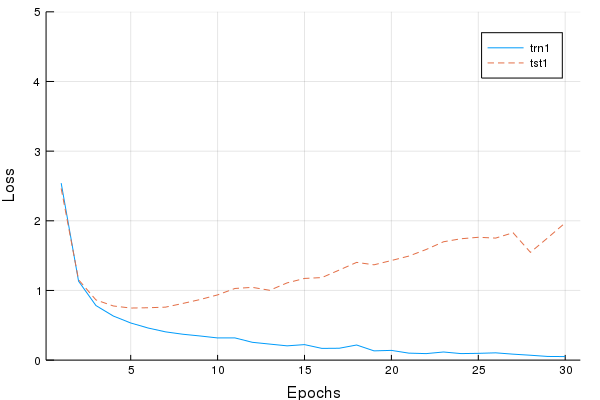

In [79]:
plot([r12[1,:], r12[2,:]], ylim=(0.0,5.0),
    labels=[:trn1 :tst1],xlabel="Epochs",ylabel="Loss")

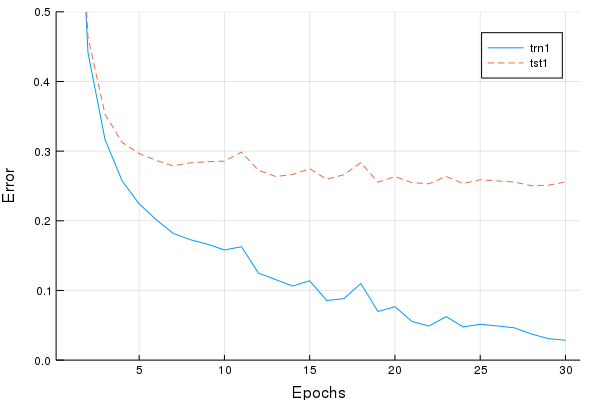

In [80]:
plot([r12[3,:], r12[4,:]], ylim=(0.0,0.5),
    labels=[:trn1 :tst1],xlabel="Epochs",ylabel="Error")

In [53]:
const timo = Knet.TimerOutput()

 ──────────────────────────────────────────────────────────────────
                           Time                   Allocations      
                   ──────────────────────   ───────────────────────
 Tot / % measured:      1.05s / 0.00%            141MiB / 0.00%    

 Section   ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────
 ──────────────────────────────────────────────────────────────────

In [113]:
Knet.@timeit timo "sleep" sleep(0.02)

In [74]:
print(timo)

 ──────────────────────────────────────────────────────────────────
                           Time                   Allocations      
                   ──────────────────────   ───────────────────────
 Tot / % measured:      42.6s / 0.13%            225MiB / 0.33%    

 Section   ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────
 sleep          2   55.7ms   100%  27.9ms    758KiB  100%    379KiB
 ──────────────────────────────────────────────────────────────────

In [77]:
function abcd()
    Knet.@timeit timo "level 2.1" sleep(0.03)
end

abcd (generic function with 1 method)

In [101]:
Knet.@timeit timo "nest 1" begin
    abcd()
end

In [81]:
print(timo)

 ───────────────────────────────────────────────────────────────────
                            Time                   Allocations      
                    ──────────────────────   ───────────────────────
  Tot / % measured:     35633s / 4.86%            205GiB / 64.3%    

 Section    ncalls     time   %tot     avg     alloc   %tot      avg
 ───────────────────────────────────────────────────────────────────
 perdim1     40.2k     575s  33.2%  14.3ms   43.7GiB  33.2%  1.11MiB
 perdim3     40.2k     571s  33.0%  14.2ms   43.7GiB  33.2%  1.11MiB
 perdim2     40.2k     571s  33.0%  14.2ms   43.7GiB  33.2%  1.11MiB
 mlphead     40.2k    7.32s  0.42%   182μs    355MiB  0.26%  9.04KiB
 mlpdep      40.2k    4.60s  0.27%   114μs    262MiB  0.19%  6.66KiB
 WH          40.2k    1.70s  0.10%  42.4μs   34.4MiB  0.03%     898B
 HWH(bmm)    40.2k    1.68s  0.10%  41.8μs   48.0MiB  0.04%  1.22KiB
 ───────────────────────────────────────────────────────────────────

In [100]:
Knet.reset_timer!(timo)

 ──────────────────────────────────────────────────────────────────
                           Time                   Allocations      
                   ──────────────────────   ───────────────────────
 Tot / % measured:      135μs / 0.00%           2.88KiB / 0.00%    

 Section   ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────
 ──────────────────────────────────────────────────────────────────

In [54]:
data4c = collect(data4_1)

12543-element Array{Tuple{Array{Int64,2},Array{Int64,1}},1}:
 ([399999 319 … 719 3], [1, 2, 2, 2, 7, 8, 2, 8, 9, 9  …  22, 19, 24, 22, 22, 29, 29, 29, 22, 2])    
 ([399999 2824 … 3 5281], [11, 4, 11, 8, 8, 8, 4, 11, 11, 1, 11, 11, 15, 11, 17, 15, 11, 11])        
 ([399999 47065 … 1236 3], [1, 2, 5, 6, 2, 10, 10, 10, 6, 10, 14, 14, 10, 14, 17, 15, 2])            
 ([399999 56 … 1793 806], [7, 4, 2, 7, 7, 1, 10, 10, 7, 13, 13, 10, 16, 16, 13, 7])                  
 ([399999 1 … 2990 3], [3, 7, 5, 3, 7, 1, 11, 11, 11, 7  …  23, 32, 32, 32, 28, 36, 36, 36, 23, 7])  
 ([399999 1 … 1002 3], [3, 6, 6, 6, 1, 9, 9, 6, 13, 13, 13, 9, 6])                                   
 ([399999 82 … 2667 3], [3, 1, 7, 7, 7, 3, 9, 7, 13, 13, 13, 7, 3])                                  
 ([399999 1 … 352 3], [3, 5, 5, 1, 13, 13, 13, 12, 12, 12, 8, 5, 16, 16, 13, 5])                     
 ([399999 377 … 6329 3], [7, 4, 7, 7, 7, 22, 9, 7, 9, 12  …  28, 24, 30, 28, 33, 33, 30, 35, 22, 22])
 ([399999 21 … 1577 3

In [60]:
lents(datdat) = map(x->length(x[1]), datdat)

lents (generic function with 1 method)

In [61]:
function minib(data4c,batchsize)
    datdat = sort(data4c, by=x->length(x[1]), rev=true)
    lentsdatdat = lents(datdat)
    uniqdat = unique(lentsdatdat)
    lennnum = [(i,count(x->x==i,lentsdatdat),j) for (j,i) in enumerate(uniqdat)]
    i=1
    j=0
    k=0
    batdat = []
    for (a,b,c) in lennnum
        bb = b
        j += b
        j = i+b
        k=j
        while bb >= batchsize
            j =i+batchsize-1
            
            push!(batdat, (cat([x[1] for x in datdat[i:j]]...,dims=1), cat([x[2] for x in datdat[i:j]]...,dims=2)))
            i=j+1
            bb -= batchsize
        end
        i += bb
    end
    batdat
end

minib (generic function with 1 method)

In [62]:
datmb2 = minib(data4c,25)

470-element Array{Any,1}:
 ([399999 201 … 425 3; 399999 1 … 3 9; … ; 399999 42 … 4353 3; 399999 50 … 28947 806], [10 3 … 5 4; 10 6 … 5 4; … ; 49 10 … 48 50; 18 10 … 5 9])         
 ([399999 42 … 379 3; 399999 20 … 7877 6939; … ; 399999 84 … 611 3; 399999 42 … 111 3], [3 4 … 4 4; 1 4 … 4 4; … ; 46 46 … 44 45; 3 9 … 18 4])           
 ([399999 9 … 963 3; 399999 201 … 25 3; … ; 399999 82 … 102 806; 399999 68 … 490 3], [41 4 … 3 4; 4 4 … 1 4; … ; 41 36 … 42 44; 41 11 … 3 4])            
 ([399999 1319 … 3398 3; 399999 35 … 1167 3; … ; 399999 1 … 22 3; 399999 2773 … 11602 806], [24 24 … 3 6; 4 6 … 6 6; … ; 41 42 … 40 42; 24 10 … 6 6])    
 ([399999 38 … 1323 3; 399999 2726 … 4520 3; … ; 399999 201 … 5342 3; 399999 1 … 547 3], [4 18 … 7 3; 4 7 … 7 31; … ; 40 38 … 35 41; 4 18 … 17 31])      
 ([399999 19 … 10556 3; 399999 49 … 6479 3; … ; 399999 42 … 3125 806; 399999 1 … 2889 3], [5 11 … 6 4; 5 7 … 6 4; … ; 38 40 … 6 40; 5 11 … 42 5])        
 ([399999 109 … 719 3; 399999 133 … 7957 3; … ; 39

In [271]:
datmb1 = minib(data4c,25)

94-element Array{Any,1}:
 ([399999 45644 … 25 3], Any[2; 4; … ; 155; 4])                                                                                                                                                             
 ([399999 193 … 5282 2693], Any[2; 4; … ; 4; 134])                                                                                                                                                          
 ([399999 9 … 806 9], Any[5; 5; … ; 5; 5])                                                                                                                                                                  
 ([399999 13 … 203 3]

[399999 400000 … 90 400000], Any[3 11; 3 5; … ; 97 11; 3 11])                                                                                                                        
 ([399999 35 … 91 3], Any[4; 4; … ; 93; 4])                                                                                                                

In [174]:
uniqdat = unique(lentsdata4)

94-element Array{Int64,1}:
 160
 136
 105
 103
 100
  98
  96
  92
  91
  90
  89
  87
  86
   ⋮
  13
  12
  11
  10
   9
   8
   7
   6
   5
   4
   3
   2

In [185]:
lennnum = [(i,count(x->x==i,lentsdata4),j) for (j,i) in enumerate(uniqdat)]

94-element Array{Tuple{Int64,Int64,Int64},1}:
 (160, 1, 1)  
 (136, 1, 2)  
 (105, 1, 3)  
 (103, 2, 4)  
 (100, 1, 5)  
 (98, 1, 6)   
 (96, 2, 7)   
 (92, 1, 8)   
 (91, 1, 9)   
 (90, 2, 10)  
 (89, 1, 11)  
 (87, 1, 12)  
 (86, 1, 13)  
 ⋮            
 (13, 473, 83)
 (12, 489, 84)
 (11, 471, 85)
 (10, 454, 86)
 (9, 429, 87) 
 (8, 435, 88) 
 (7, 446, 89) 
 (6, 419, 90) 
 (5, 370, 91) 
 (4, 492, 92) 
 (3, 622, 93) 
 (2, 521, 94) 

In [264]:
i=1
j=0
batdat = []
for (a,b,c) in lennnum
    j += b
    push!(batdat, (cat([x[1] for x in data4cs[i:j]]...,dims=3), cat([x[2] for x in data4cs[i:j]]...,dims=2)))
    i=j+1
end

In [169]:
lentsdata4 = lents(data4cs)

12543-element Array{Int64,1}:
 160
 136
 105
 103
 103
 100
  98
  96
  96
  92
  91
  90
  90
   ⋮
   2
   2
   2
   2
   2
   2
   2
   2
   2
   2
   2
   2